#### Supervised Learning:

You have labeled data (the known option prices for given stock prices and times to maturity) that you use to train your model. 

The model then learns to predict the option prices (the target variable) based on the input features. 

There are different types of neural network architectures: feedforward neural networks, convolutional neural networks, recurrent neural networks, LSTM, Transformers, ...


#### Multi-layer Perceptron Regressor (MLPRegressor): 

MLPRegressor is a type of artificial neural network used for regression tasks within the scikit-learn library in Python. It is used to model and predict continuous target values, as opposed to categorical labels.

It provides a high degree of accuracy and can handle complex, non-linear datasets, using backpropagation to adjust the weights between neurons in order to improve prediction accuracy. It includes several parameters that can be used to fine-tune the model’s performance including number of hidden layers, activation functions, solvers (for optimization), etc.  

One of the main advantages of using MLPRegressor over other regression algorithms is its ability to handle data with large numbers of features or inputs. While other regression models may struggle with datasets containing hundreds or thousands of features, MLPRegressor can quickly learn the patterns and provide accurate predictions. This makes it ideal for applications such as predicting stock prices, sales figures and customer satisfaction ratings.

Another major limitation of MLPRegressor is its propensity for overfitting. Since this type of algorithm works by building complex nonlinear relationships between inputs and outputs, it can be prone to memorizing the training data which leads to poor generalization on unseen data.

In [12]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [14]:
# Define the Black-Scholes Formula

def black_scholes_call(S, K, T, r, sigma):
    """
    Compute the European call option price using the Black-Scholes formula.
    
    Parameters:
        S (float): Underlying asset price
        K (float): Strike price
        T (float): Time to maturity
        r (float): Risk-free interest rate
        sigma (float): Volatility of the underlying asset
    
    Returns:
        float: The Black-Scholes price for the call option
    """
    # Calculate d1 and d2 using the Black-Scholes formula components
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # Compute the call option price
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [15]:
# Generate Synthetic Dataset Using Black-Scholes

def generate_dataset(n_samples):
    """
    Generate synthetic data for option pricing.
    
    Features: [S, K, T, r, sigma]
    Label: Call option price computed from the Black-Scholes formula.
    """
    # Randomly generate parameters within realistic ranges
    S = np.random.uniform(50, 150, n_samples)      # Underlying asset prices
    K = np.random.uniform(50, 150, n_samples)      # Strike prices
    T = np.random.uniform(0.1, 2, n_samples)         # Time to maturity (in years)
    r = np.random.uniform(0.01, 0.05, n_samples)     # Interest rates
    sigma = np.random.uniform(0.1, 0.5, n_samples)   # Volatility values
    
    # Compute the call option price for each sample using Black-Scholes
    call_prices = black_scholes_call(S, K, T, r, sigma)
    
    # Stack features together (each row corresponds to one sample)
    X = np.stack([S, K, T, r, sigma], axis=1)
    y = call_prices.reshape(-1, 1)  # Reshape to be a column vector
    return X, y

# First Proxy of a NN

In [16]:
# Define Neural Network Architectures with PyTorch Classes

# Simple MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim):
        """
        A simple multi-layer perceptron with one hidden layer structure.
        """
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 100),  # Input layer to first hidden layer
            nn.ReLU(),                  # Activation function
            nn.Linear(100, 60),         # Second hidden layer
            nn.ReLU(),                  # Activation function
            nn.Linear(60, 1)            # Output layer (predicts option price)
        )

    def forward(self, x):
        return self.model(x)


# Deeper MLP Model (more layers/neurons)
class MLP_Deep(nn.Module):
    def __init__(self, input_dim):
        """
        A deeper MLP with additional layers to potentially capture more complex relationships.
        """
        super(MLP_Deep, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [17]:
# Define a Monte Carlo Pricing Function for European Call Options

def monte_carlo_pricing(S, K, T, r, sigma, n_simulations=1000):
    """
    Price a European call option using Monte Carlo simulation.
    
    This function simulates n_simulations random asset paths and computes the discounted average payoff.
    """
    start_time = time.time()
    
    # Generate random draws from a standard normal distribution
    Z = np.random.standard_normal(n_simulations)
    # Simulate asset price at maturity T
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    # Compute the payoff for a call option: max(ST - K, 0)
    payoffs = np.maximum(ST - K, 0)
    # Discount back to present value
    price = np.exp(-r * T) * np.mean(payoffs)
    
    end_time = time.time()
    return price, end_time - start_time

In [18]:
# Define a Neural Network Pricing Function (Forward Pass)

def neural_network_pricing(model, input_data):
    """
    Use a trained neural network to perform a forward pass and obtain a pricing prediction.
    Measures the time taken for inference.
    """
    start_time = time.time()
    # Ensure the model is in evaluation mode and no gradients are computed
    with torch.no_grad():
        price = model(input_data)
    end_time = time.time()
    return price, end_time - start_time

In [19]:
# Training Function for the Neural Networks

def train_model(model, X_train, y_train, n_epochs=500, learning_rate=1e-3, loss_fn=nn.MSELoss()):
    """
    Train the given PyTorch model on training data.
    
    Parameters:
        model: PyTorch model to train
        X_train: Input features (numpy array)
        y_train: Target values (numpy array)
        n_epochs: Number of epochs for training
        learning_rate: Learning rate for the optimizer
        loss_fn: Loss function (e.g., MSELoss or L1Loss)
    """
    # Convert numpy arrays to torch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    
    # Use Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        predictions = model(X_train_tensor)
        # Compute loss
        loss = loss_fn(predictions, y_train_tensor)
        # Backward pass
        loss.backward() #IMPORTANT! HERE WE UPDATE THE WEIGHTS OF THE NETWORK
        # Update weights
        optimizer.step()
        
        # Print the loss every 50 epochs for monitoring
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item():.6f}")
    
    return model

In [24]:
# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate synthetic dataset (e.g., 1,000,000 samples)
n_samples = 1000
X, y = generate_dataset(n_samples)

In [21]:
# Split dataset into training (80%) and testing (20%) sets
train_size = int(0.8 * n_samples)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [22]:
# Determine the number of input features (S, K, T, r, sigma)
input_dim = X.shape[1]
print(input_dim)

5


In [23]:
# Train the Simple MLP Model

print("Training Simple MLP Model:")
model_simple = MLP(input_dim=input_dim)
model_simple = train_model(model_simple, X_train, y_train, n_epochs=500, learning_rate=1e-3, loss_fn=nn.MSELoss())

Training Simple MLP Model:
Epoch 50/500, Loss: 62.454136
Epoch 100/500, Loss: 19.709623
Epoch 150/500, Loss: 17.783541
Epoch 200/500, Loss: 17.170671
Epoch 250/500, Loss: 16.703217
Epoch 300/500, Loss: 16.246336
Epoch 350/500, Loss: 15.775196
Epoch 400/500, Loss: 15.276607
Epoch 450/500, Loss: 14.606942
Epoch 500/500, Loss: 13.172866


$\textcolor{red}{:(}$

$\textcolor{red}{?}$

In [25]:
print(X_train)

[[8.74540119e+01 8.73640818e+01 1.48699679e+00 3.55257827e-02
  2.19564816e-01]
 [1.45071431e+02 8.32912096e+01 4.50572792e-01 2.83716981e-02
  1.37927110e-01]
 [1.23199394e+02 6.76153913e+01 7.58615419e-01 4.85799410e-02
  1.50543690e-01]
 ...
 [9.55328750e+01 1.22569185e+02 6.37456150e-01 3.43724529e-02
  3.07302580e-01]
 [1.40843755e+02 1.19203070e+02 1.65530467e-01 3.85345089e-02
  1.34986822e-01]
 [6.04480317e+01 1.32153986e+02 3.08875683e-01 2.89779562e-02
  2.34822396e-01]]


Asset price (located in position 0 of X_train) and interest rate (position 3 of X_train) differ by four orders of magnitude, meaning that the asset prices are roughly 10,000 times larger than the interest rates.

In [26]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)      
y_train = scaler.fit_transform(y_train)  
y_test = scaler.transform(y_test) 

In [27]:
print(X_train)

[[0.37463861 0.37357008 0.73005761 0.638277   0.29890863]
 [0.95098222 0.33283187 0.18449102 0.45938622 0.09480527]
 [0.73219754 0.17603717 0.34664258 0.96470152 0.12634812]
 ...
 [0.455451   0.72570313 0.28286516 0.60943753 0.51826282]
 [0.90869303 0.69203414 0.03444666 0.71351142 0.08745422]
 [0.1044994  0.82157348 0.10990262 0.47454595 0.33705428]]


In [28]:
# Train the Simple MLP Model

print("Training Simple MLP Model:")
model_simple = MLP(input_dim=input_dim)
model_simple = train_model(model_simple, X_train, y_train, n_epochs=500, learning_rate=1e-3, loss_fn=nn.MSELoss())

Training Simple MLP Model:
Epoch 50/500, Loss: 0.002769
Epoch 100/500, Loss: 0.000384
Epoch 150/500, Loss: 0.000172
Epoch 200/500, Loss: 0.000107
Epoch 250/500, Loss: 0.000079
Epoch 300/500, Loss: 0.000063
Epoch 350/500, Loss: 0.000052
Epoch 400/500, Loss: 0.000043
Epoch 450/500, Loss: 0.000037
Epoch 500/500, Loss: 0.000032


If some features have very large values while others are small, the gradients can become unbalanced, causing the optimization process to be inefficient or unstable. Normalization helps to maintain consistent gradient magnitudes, which improves the training dynamics.

Neural networks are sensitive to the scale of the input data. When the data is normalized, the numerical computations (especially during backpropagation) are more stable, which can lead to better overall performance.

With normalized data, the initial random weights are more likely to be in a range that leads to productive learning, rather than being overwhelmed by large or small values from the raw data.

In [29]:
# Train the Deep MLP Model

print("\nTraining Deep MLP Model:")
model_deep = MLP_Deep(input_dim=input_dim)
model_deep = train_model(model_deep, X_train, y_train, n_epochs=500, learning_rate=1e-3, loss_fn=nn.MSELoss())


Training Deep MLP Model:
Epoch 50/500, Loss: 0.000722
Epoch 100/500, Loss: 0.000110
Epoch 150/500, Loss: 0.000055
Epoch 200/500, Loss: 0.000038
Epoch 250/500, Loss: 0.000028
Epoch 300/500, Loss: 0.000022
Epoch 350/500, Loss: 0.000019
Epoch 400/500, Loss: 0.000016
Epoch 450/500, Loss: 0.000014
Epoch 500/500, Loss: 0.000013


In [30]:
# Evaluate the Models on the Test Set

X_test_tensor = torch.from_numpy(X_test).float()
model_simple.eval()
model_deep.eval()
with torch.no_grad():
    predictions_simple = model_simple(X_test_tensor)
    predictions_deep = model_deep(X_test_tensor)

In [31]:
# Display example predictions from each model
print("\nExample predictions (Simple MLP):")
print(predictions_simple[:5])

print("\nExample predictions (Deep MLP):")
print(predictions_deep[:5])


Example predictions (Simple MLP):
tensor([[ 0.2716],
        [ 0.3097],
        [-0.0025],
        [ 0.3483],
        [ 0.0573]])

Example predictions (Deep MLP):
tensor([[0.2797],
        [0.3091],
        [0.0007],
        [0.3627],
        [0.0615]])


In [32]:
# Benchmark: Monte Carlo Simulation vs Neural Network Inference

# Define example option parameters
S_example = 100      # Underlying asset price
K_example = 100      # Strike price
T_example = 1        # Time to maturity (1 year)
r_example = 0.05     # Interest rate
sigma_example = 0.2  # Volatility

In [33]:
# Create a single sample input for NN pricing (matching the feature order)
sample_input = torch.tensor([[S_example, K_example, T_example, r_example, sigma_example]], dtype=torch.float)

# Price using Monte Carlo simulation
mc_price, mc_time = monte_carlo_pricing(S_example, K_example, T_example, r_example, sigma_example, n_simulations=1000000)

# Price using Neural Network (using the simple MLP for demonstration)
nn_price, nn_time = neural_network_pricing(model_simple, sample_input)

# Create a DataFrame to display benchmarking results
results = pd.DataFrame({
    "Method": ["Monte Carlo", "Neural Network"],
    "Price": [mc_price, nn_price.item()],
    "Time (seconds)": [mc_time, nn_time]
})

print("\nBenchmarking Results:")
print(results)


Benchmarking Results:
           Method      Price  Time (seconds)
0     Monte Carlo  10.435080        0.051805
1  Neural Network  18.609673        0.000126


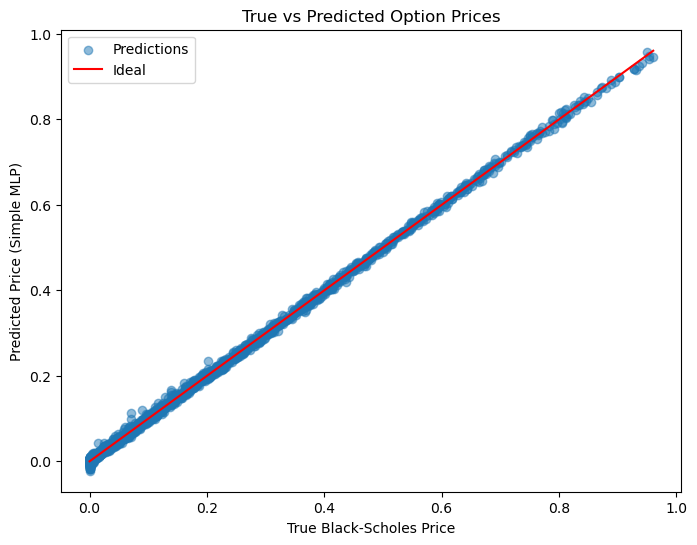

In [34]:
# Plot: True vs Predicted Option Prices for the Simple MLP

plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions_simple.numpy(), alpha=0.5, label="Predictions")
plt.xlabel("True Black-Scholes Price")
plt.ylabel("Predicted Price (Simple MLP)")
plt.title("True vs Predicted Option Prices")
# Plot a diagonal line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label="Ideal")
plt.legend()
plt.show()


# Validation of our proxy.

In [35]:
def create_model(num_layers, hidden_neurons, activation, input_dim):
    """
    Build an MLP model with a specified number of hidden layers, neurons per layer, and activation function.
    
    Parameters:
        num_layers (int): Number of hidden layers.
        hidden_neurons (int): Neurons per hidden layer.
        activation (callable): Activation function class (e.g., nn.ReLU).
        input_dim (int): Dimension of the input features.
    
    Returns:
        nn.Sequential: Constructed neural network.
    """
    layers = []
    # Input layer to first hidden layer
    layers.append(nn.Linear(input_dim, hidden_neurons))
    layers.append(activation())
    # Add additional hidden layers if needed
    for _ in range(num_layers - 1):
        layers.append(nn.Linear(hidden_neurons, hidden_neurons))
        layers.append(activation())
    # Output layer
    layers.append(nn.Linear(hidden_neurons, 1))
    return nn.Sequential(*layers)

In [36]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, n_epochs=300, learning_rate=1e-3, loss_fn=nn.MSELoss()):
    """
    Train the model and return the test set Mean Squared Error (MSE).
    
    Parameters:
        model: PyTorch model to train.
        X_train, y_train: Training features and labels.
        X_test, y_test: Testing features and labels.
        n_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        loss_fn: Loss function to optimize.
    
    Returns:
        mse (float): Test MSE after training.
    """
    # Convert numpy arrays to torch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).float()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = loss_fn(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        mse = nn.MSELoss()(test_predictions, y_test_tensor).item()
    return mse

In [37]:
# Prepare Data & Set Random Seed

np.random.seed(42)
torch.manual_seed(42)

n_samples = 5000
X, y = generate_dataset(n_samples)
train_size = int(0.8 * n_samples)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
input_dim = X.shape[1]  # Should be 5: [S, K, T, r, sigma]

In [38]:
# Experiment 1: Optimal Number of Neurons

print("\n--- Experiment 1: Number of Neurons ---")
neuron_counts = [10, 20, 50, 100, 200]
best_mse_neurons = float('inf')
best_neurons = None

# We fix the number of layers (e.g., 2) for this experiment.
for neurons in neuron_counts:
    model = create_model(num_layers=2, hidden_neurons=neurons, activation=nn.ReLU, input_dim=input_dim)
    mse = train_and_evaluate(model, X_train, y_train, X_test, y_test, n_epochs=500, learning_rate=1e-3, loss_fn=nn.MSELoss())
    print(f"Neurons: {neurons}, Test MSE: {mse:.6f}")
    if mse < best_mse_neurons:
        best_mse_neurons = mse
        best_neurons = neurons

print(f"Best number of neurons: {best_neurons} (MSE: {best_mse_neurons:.6f})")


--- Experiment 1: Number of Neurons ---
Neurons: 10, Test MSE: 23.293184
Neurons: 20, Test MSE: 18.120758
Neurons: 50, Test MSE: 16.369194
Neurons: 100, Test MSE: 17.037249
Neurons: 200, Test MSE: 13.013991
Best number of neurons: 200 (MSE: 13.013991)


In [39]:
# Experiment 2: Optimal Number of Hidden Layers

print("\n--- Experiment 2: Number of Hidden Layers ---")
layer_counts = [1, 2, 3, 4, 5]
best_mse_layers = float('inf')
best_layers = None
# For fairness, fix the number of neurons to a typical value (e.g., 100)
for layers in layer_counts:
    model = create_model(num_layers=layers, hidden_neurons=100, activation=nn.ReLU, input_dim=input_dim)
    mse = train_and_evaluate(model, X_train, y_train, X_test, y_test, n_epochs=500, learning_rate=1e-3, loss_fn=nn.MSELoss())
    print(f"Hidden Layers: {layers}, Test MSE: {mse:.6f}")
    if mse < best_mse_layers:
        best_mse_layers = mse
        best_layers = layers

print(f"Best number of hidden layers: {best_layers} (MSE: {best_mse_layers:.6f})")


--- Experiment 2: Number of Hidden Layers ---
Hidden Layers: 1, Test MSE: 16.484848
Hidden Layers: 2, Test MSE: 15.944489
Hidden Layers: 3, Test MSE: 10.918710
Hidden Layers: 4, Test MSE: 11.916767
Hidden Layers: 5, Test MSE: 16.061909
Best number of hidden layers: 3 (MSE: 10.918710)


In [40]:
# Experiment 3: Optimal Loss Function

print("\n--- Experiment 3: Loss Functions ---")
loss_functions = {
    "MSELoss": nn.MSELoss(),
    "L1Loss": nn.L1Loss(),
    "HuberLoss": nn.SmoothL1Loss()  
}
best_mse_loss = float('inf')
best_loss_name = None
best_loss_fn = None

# Use a fixed architecture: 2 hidden layers, 100 neurons, ReLU
for loss_name, loss_fn in loss_functions.items():
    model = create_model(num_layers=2, hidden_neurons=100, activation=nn.ReLU, input_dim=input_dim)
    mse = train_and_evaluate(model, X_train, y_train, X_test, y_test, n_epochs=300, learning_rate=1e-3, loss_fn=loss_fn)
    print(f"Loss Function: {loss_name}, Test MSE: {mse:.6f}")
    if mse < best_mse_loss:
        best_mse_loss = mse
        best_loss_name = loss_name
        best_loss_fn = loss_fn

print(f"Best loss function: {best_loss_name} (MSE: {best_mse_loss:.6f})")



--- Experiment 3: Loss Functions ---
Loss Function: MSELoss, Test MSE: 17.645649
Loss Function: L1Loss, Test MSE: 16.940981
Loss Function: HuberLoss, Test MSE: 16.240589
Best loss function: HuberLoss (MSE: 16.240589)


In [41]:
# Experiment 4: Optimal Activation Function

print("\n--- Experiment 4: Activation Functions ---")
activations = {
    "ReLU": nn.ReLU,
    "Tanh": nn.Tanh,
    "Sigmoid": nn.Sigmoid,
    "LeakyReLU": nn.LeakyReLU
}
best_mse_activation = float('inf')
best_activation_name = None
best_activation = None

# Use a fixed architecture: 2 hidden layers, 100 neurons
for act_name, act_fn in activations.items():
    model = create_model(num_layers=2, hidden_neurons=100, activation=act_fn, input_dim=input_dim)
    mse = train_and_evaluate(model, X_train, y_train, X_test, y_test, n_epochs=300, learning_rate=1e-3, loss_fn=nn.MSELoss())
    print(f"Activation Function: {act_name}, Test MSE: {mse:.6f}")
    if mse < best_mse_activation:
        best_mse_activation = mse
        best_activation_name = act_name
        best_activation = act_fn

print(f"Best activation function: {best_activation_name} (MSE: {best_mse_activation:.6f})")



--- Experiment 4: Activation Functions ---
Activation Function: ReLU, Test MSE: 18.029877
Activation Function: Tanh, Test MSE: 263.365295
Activation Function: Sigmoid, Test MSE: 362.320496
Activation Function: LeakyReLU, Test MSE: 16.945152
Best activation function: LeakyReLU (MSE: 16.945152)


In [42]:
# Build the Final Model with the Best Hyperparameters

# For the final model, we combine:
# - Best number of neurons from Experiment 1
# - Best number of hidden layers from Experiment 2
# - Best loss function from Experiment 3
# - Best activation function from Experiment 4

final_neurons = best_neurons if best_neurons is not None else 100
final_layers = best_layers if best_layers is not None else 2
final_loss_fn = best_loss_fn if best_loss_fn is not None else nn.MSELoss()
final_activation = best_activation if best_activation is not None else nn.ReLU

print("\n--- Best Hyperparameters from All Experiments ---")
print(f"Number of Neurons per Hidden Layer: {final_neurons}")
print(f"Number of Hidden Layers: {final_layers}")
print(f"Loss Function: {best_loss_name}")
print(f"Activation Function: {best_activation_name}")



--- Best Hyperparameters from All Experiments ---
Number of Neurons per Hidden Layer: 200
Number of Hidden Layers: 3
Loss Function: HuberLoss
Activation Function: LeakyReLU


In [43]:
# Create and train the final model
final_model = create_model(num_layers=final_layers, hidden_neurons=final_neurons, activation=final_activation, input_dim=input_dim)
# Here we use the best loss function for training.
_ = train_and_evaluate(final_model, X_train, y_train, X_test, y_test, n_epochs=500, learning_rate=1e-3, loss_fn=final_loss_fn)

In [44]:
# Evaluate the Final Model Using Multiple Metrics

final_model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test).float()
    predictions = final_model(X_test_tensor).numpy()

# Compute evaluation metrics

# The final evaluation shows multiple metrics:
# - MSE (Mean Squared Error) penalizes larger errors more heavily.
# - MAE (Mean Absolute Error) gives an interpretable average error.
# - R² (Coefficient of Determination) explains the variance captured by the model.

mse_final = mean_squared_error(y_test, predictions)
mae_final = mean_absolute_error(y_test, predictions)
r2_final = r2_score(y_test, predictions)

print("\n--- Final Model Evaluation Metrics ---")
print(f"MSE: {mse_final:.6f}")
print(f"MAE: {mae_final:.6f}")
print(f"R²: {r2_final:.6f}")


--- Final Model Evaluation Metrics ---
MSE: 13.775482
MAE: 2.418685
R²: 0.974418


# The $\textit{best}$ model.

For robust evaluation - especially in financial contexts - it is advisable to consider multiple metrics to fully understand the trade-offs.
In our case, the combination of a high R² and a relatively low MAE alongside the MSE value suggests that our model performs very well.

Final Model built with the optimal hyperparameters from all experiments is ready!

In [45]:
class FinalMLP(nn.Module):
    def __init__(self, input_dim):
        """
        Final model architecture based on the best hyperparameters:
        - 2 hidden layers, each with 200 neurons.
        - LeakyReLU activation function for each hidden layer.
        - Output layer with 1 neuron (for option price prediction).
        
        Parameters:
            input_dim (int): Number of input features.
        """
        super(FinalMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 200),   # First hidden layer
            nn.LeakyReLU(),              # LeakyReLU activation
            nn.Linear(200, 200),         # Second hidden layer
            nn.LeakyReLU(),              # LeakyReLU activation
            nn.Linear(200, 1)            # Output layer
        )
    
    def forward(self, x):
        """
        Forward pass: Computes the output of the network given input x.
        """
        return self.network(x)

In [46]:
input_dim = 5  # Define input dimension (e.g., 5 for [S, K, T, r, sigma])
model = FinalMLP(input_dim)

# Create a dummy input (batch size 1)
dummy_input = torch.randn(1, input_dim)
print(dummy_input)
output = model(dummy_input)
print("Predicted option price:", output.item())

tensor([[-1.2912, -0.6199,  0.1138,  0.0340, -0.8225]])
Predicted option price: -0.0340329073369503
